In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

<AxesSubplot:>

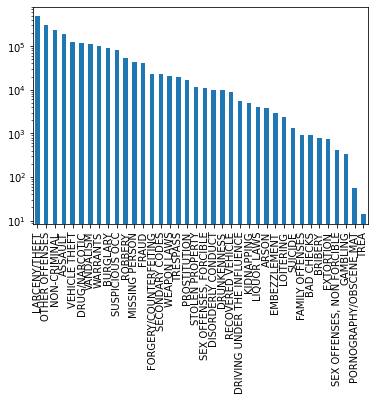

In [2]:
df['Category'].value_counts().plot(kind="bar", logy=True)

# Loglog-graphs

In [3]:
df["longitude"] = df.location.apply(lambda x: float(x.replace("POINT (", "").replace(")", "").split()[0]))
df["latitude"] = df.location.apply(lambda x: float(x.replace("POINT (", "").replace(")", "").split()[1]))

real_coords = df.loc[df.latitude < 45]
print("{} to {}\n{} to {}".format(min(real_coords.longitude), max(real_coords.longitude), min(real_coords.latitude), max(real_coords.latitude)))

-122.51364206428998 to -122.36475070439299
37.7078790224135 to 37.820620838070205


In [4]:
from math import cos, pi

delta_latitude = max(real_coords.latitude) - min(real_coords.latitude)
delta_longitude = max(real_coords.longitude) - min(real_coords.longitude)

meters_lat = (delta_latitude) * 40008000 / 360
def asRadians(degrees):
    return degrees * pi / 180

meters_long = delta_longitude * 40075160 * cos(asRadians(max(real_coords.latitude))) / 360
(meters_lat, meters_long)

(12529.373779981772, 13092.822310109737)

In [5]:
number_bins_lat = round(meters_lat/100)
number_bins_long = round(meters_long/100)
number_bins_lat, number_bins_long

(125, 131)

In [6]:
import numpy as np

#_, lat, long = np.histogram2d(real_coords.latitude, real_coords.longitude, [number_bins_lat, number_bins_long])

step = delta_longitude/number_bins_long
to_bin_lat = lambda x: np.round(x / step) * step
df["latbin"] = df.latitude.map(to_bin_lat)

step = delta_latitude/number_bins_lat
to_bin_long = lambda x: np.round(x / step) * step
df["lonbin"] = df.longitude.map(to_bin_long)
real_coords = df.loc[df.latitude < 45]

#df.columns
groups = real_coords.groupby(["latbin", "lonbin"])

In [7]:
groups = real_coords.groupby(["latbin", "lonbin"])

crimes = groups.Category.agg('count')
n = []

max(crimes)
#crimes.value_counts().sort_values()

n = crimes.value_counts().sort_index()

In [8]:
n

1        65
2        56
3        40
4        53
5        40
         ..
9967      1
11139     1
13195     1
14377     1
63805     1
Name: Category, Length: 1119, dtype: int64

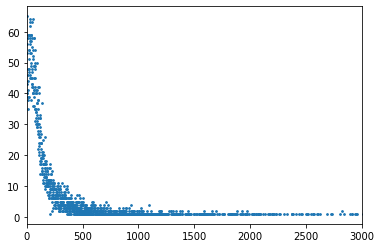

In [20]:
plt.yscale('linear')
plt.xlim(0,3000)
plt.scatter(n.index, n, s=3)
#plt.plot(n, 'o')
plt.show()

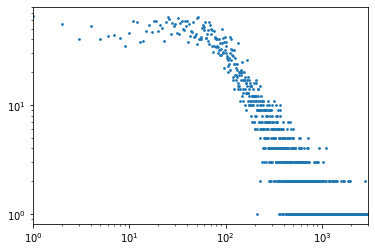

In [21]:
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,3000)
plt.scatter(n.index, n, s=3)
plt.show()

## Linear regression

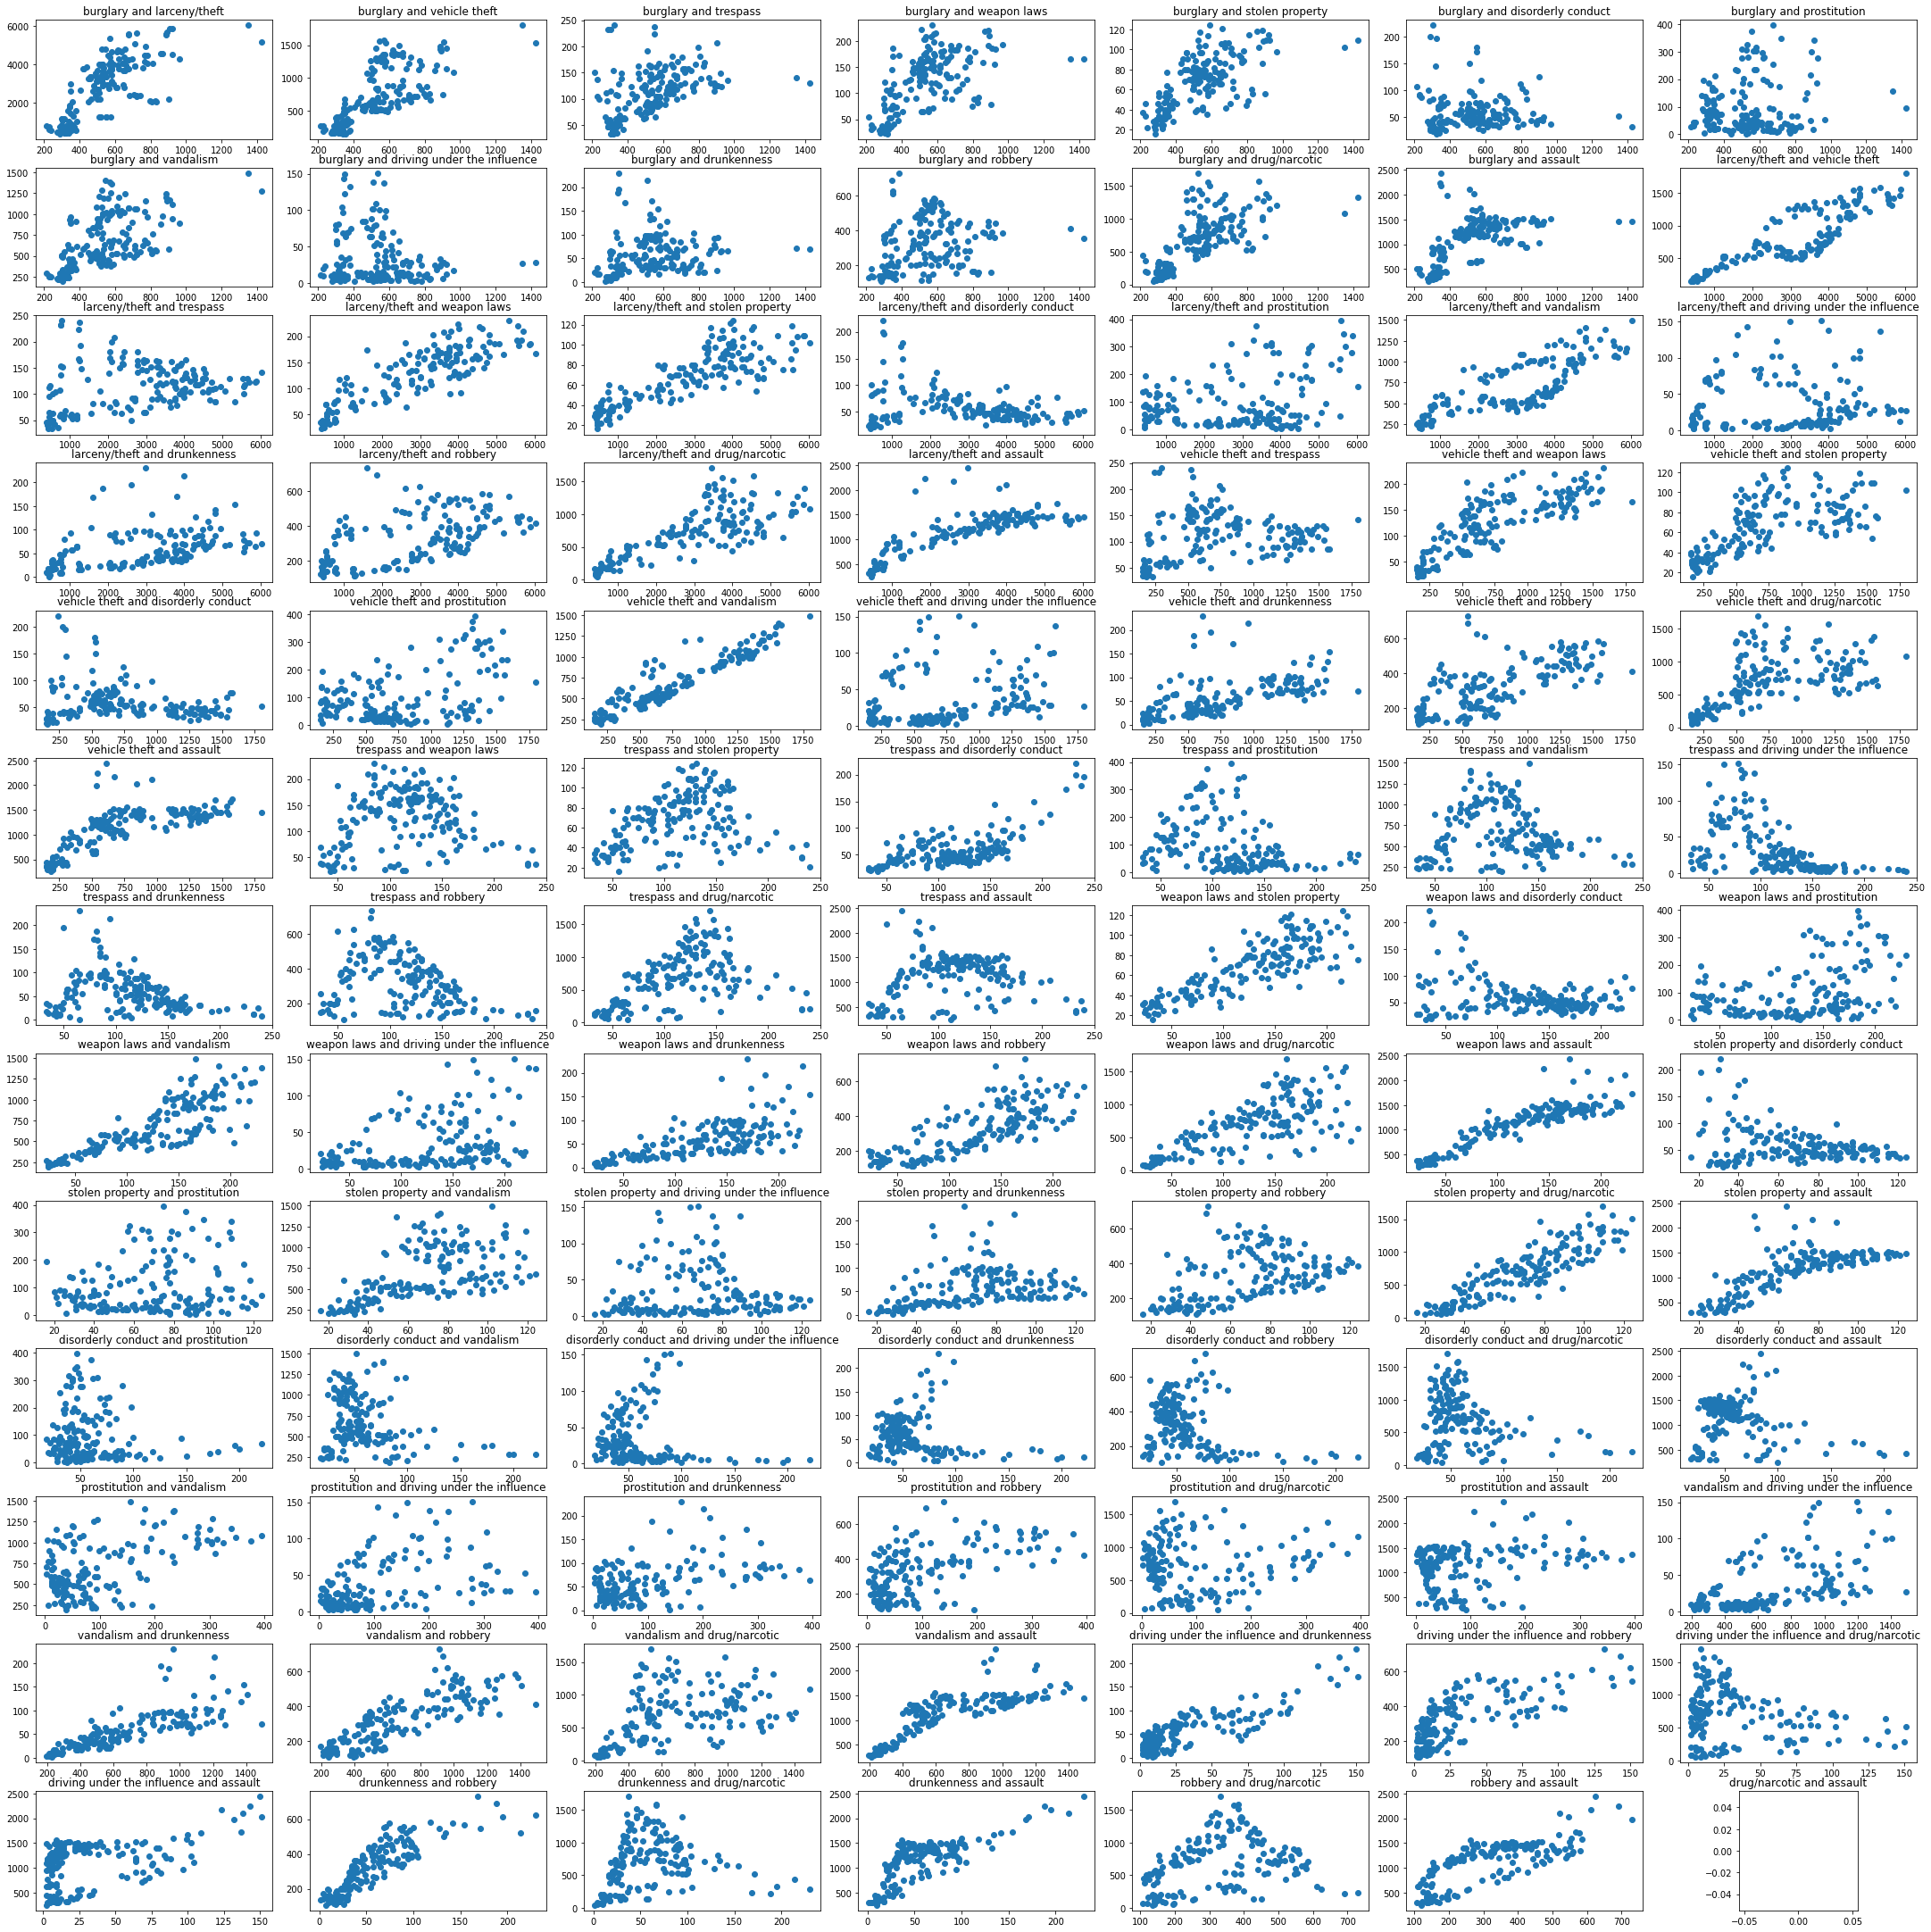

In [23]:
from itertools import combinations
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

df['Date'] = pd.to_datetime(df['Date'])
fig, axes = plt.subplots(ncols=7, nrows=13, figsize=(30,30))
plt.tight_layout()
df['Time'] = pd.to_datetime(df['Time'])
df["HourOfWeek"] = df.Date.dt.dayofweek*24+df.Time.dt.hour
plt.axis('scaled')

for (crime1, crime2), ax in zip(combinations(focuscrimes, r=2), axes.flat):
    x = df.HourOfWeek.loc[df.Category == crime1].groupby(df.HourOfWeek).agg('count').sort_values()
    y = df.HourOfWeek.loc[df.Category == crime2].groupby(df.HourOfWeek).agg('count').sort_values()
    ax.scatter(x.sort_index(), y.sort_index())
    
    #ax.scatter(x, y)
    ax.title.set_text("{} and {}".format(crime1.lower(), crime2.lower()))

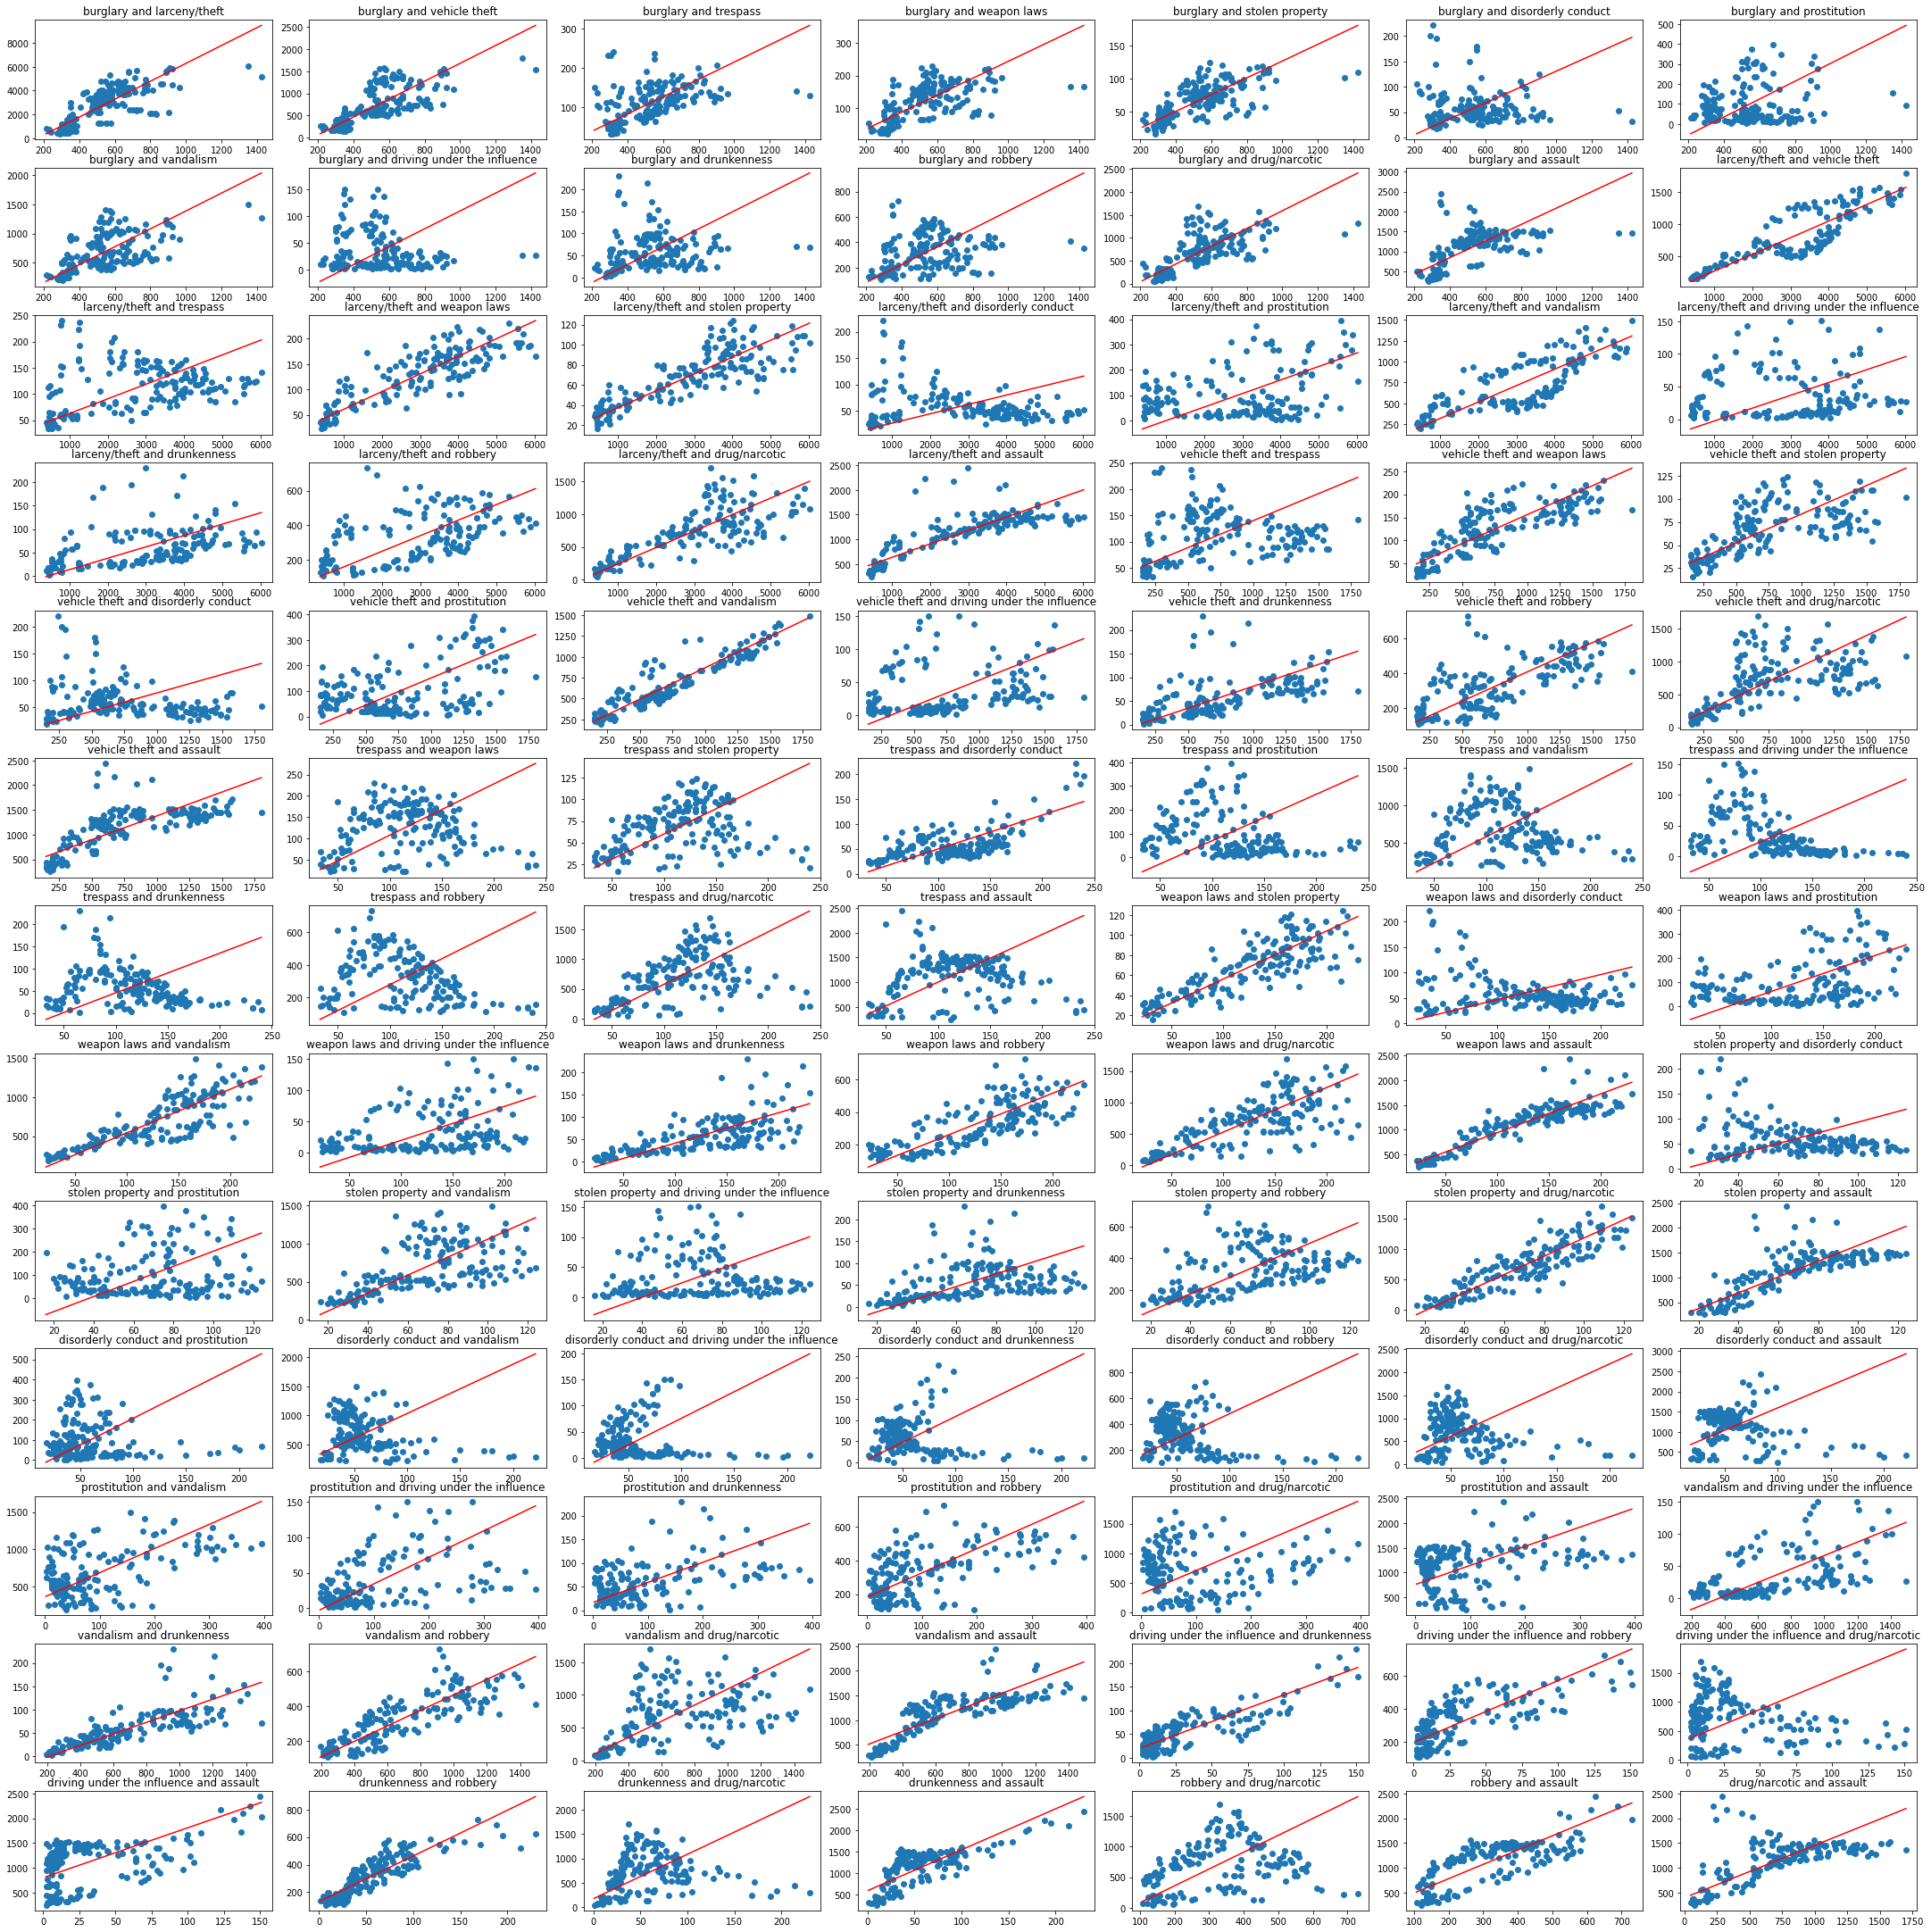

In [12]:
fig, axes = plt.subplots(ncols=7, nrows=13, figsize=(30,30))
plt.tight_layout()

for (crime1, crime2), ax in zip(combinations(focuscrimes, r=2), axes.flat):
    x = df.HourOfWeek.loc[df.Category == crime1].groupby(df.HourOfWeek).agg('count').sort_values()
    y = df.HourOfWeek.loc[df.Category == crime2].groupby(df.HourOfWeek).agg('count').sort_values()
    
    xy = 0
    x2 = 0
    
    for val_x, val_y in zip(x,y):
        xy += val_x*val_y
        x2 += val_x**2
    
    a = (xy-len(x)*np.mean(x)*np.mean(y))/(x2-len(x)*np.mean(x)**2)
    b = np.mean(y) - a*np.mean(x)
    
    ax.scatter(x.sort_index(), y.sort_index())
    
    #ax.scatter(x, y)
    ax.plot(x, b+a*x, 'r')
    ax.title.set_text("{} and {}".format(crime1.lower(), crime2.lower()))

## With colors

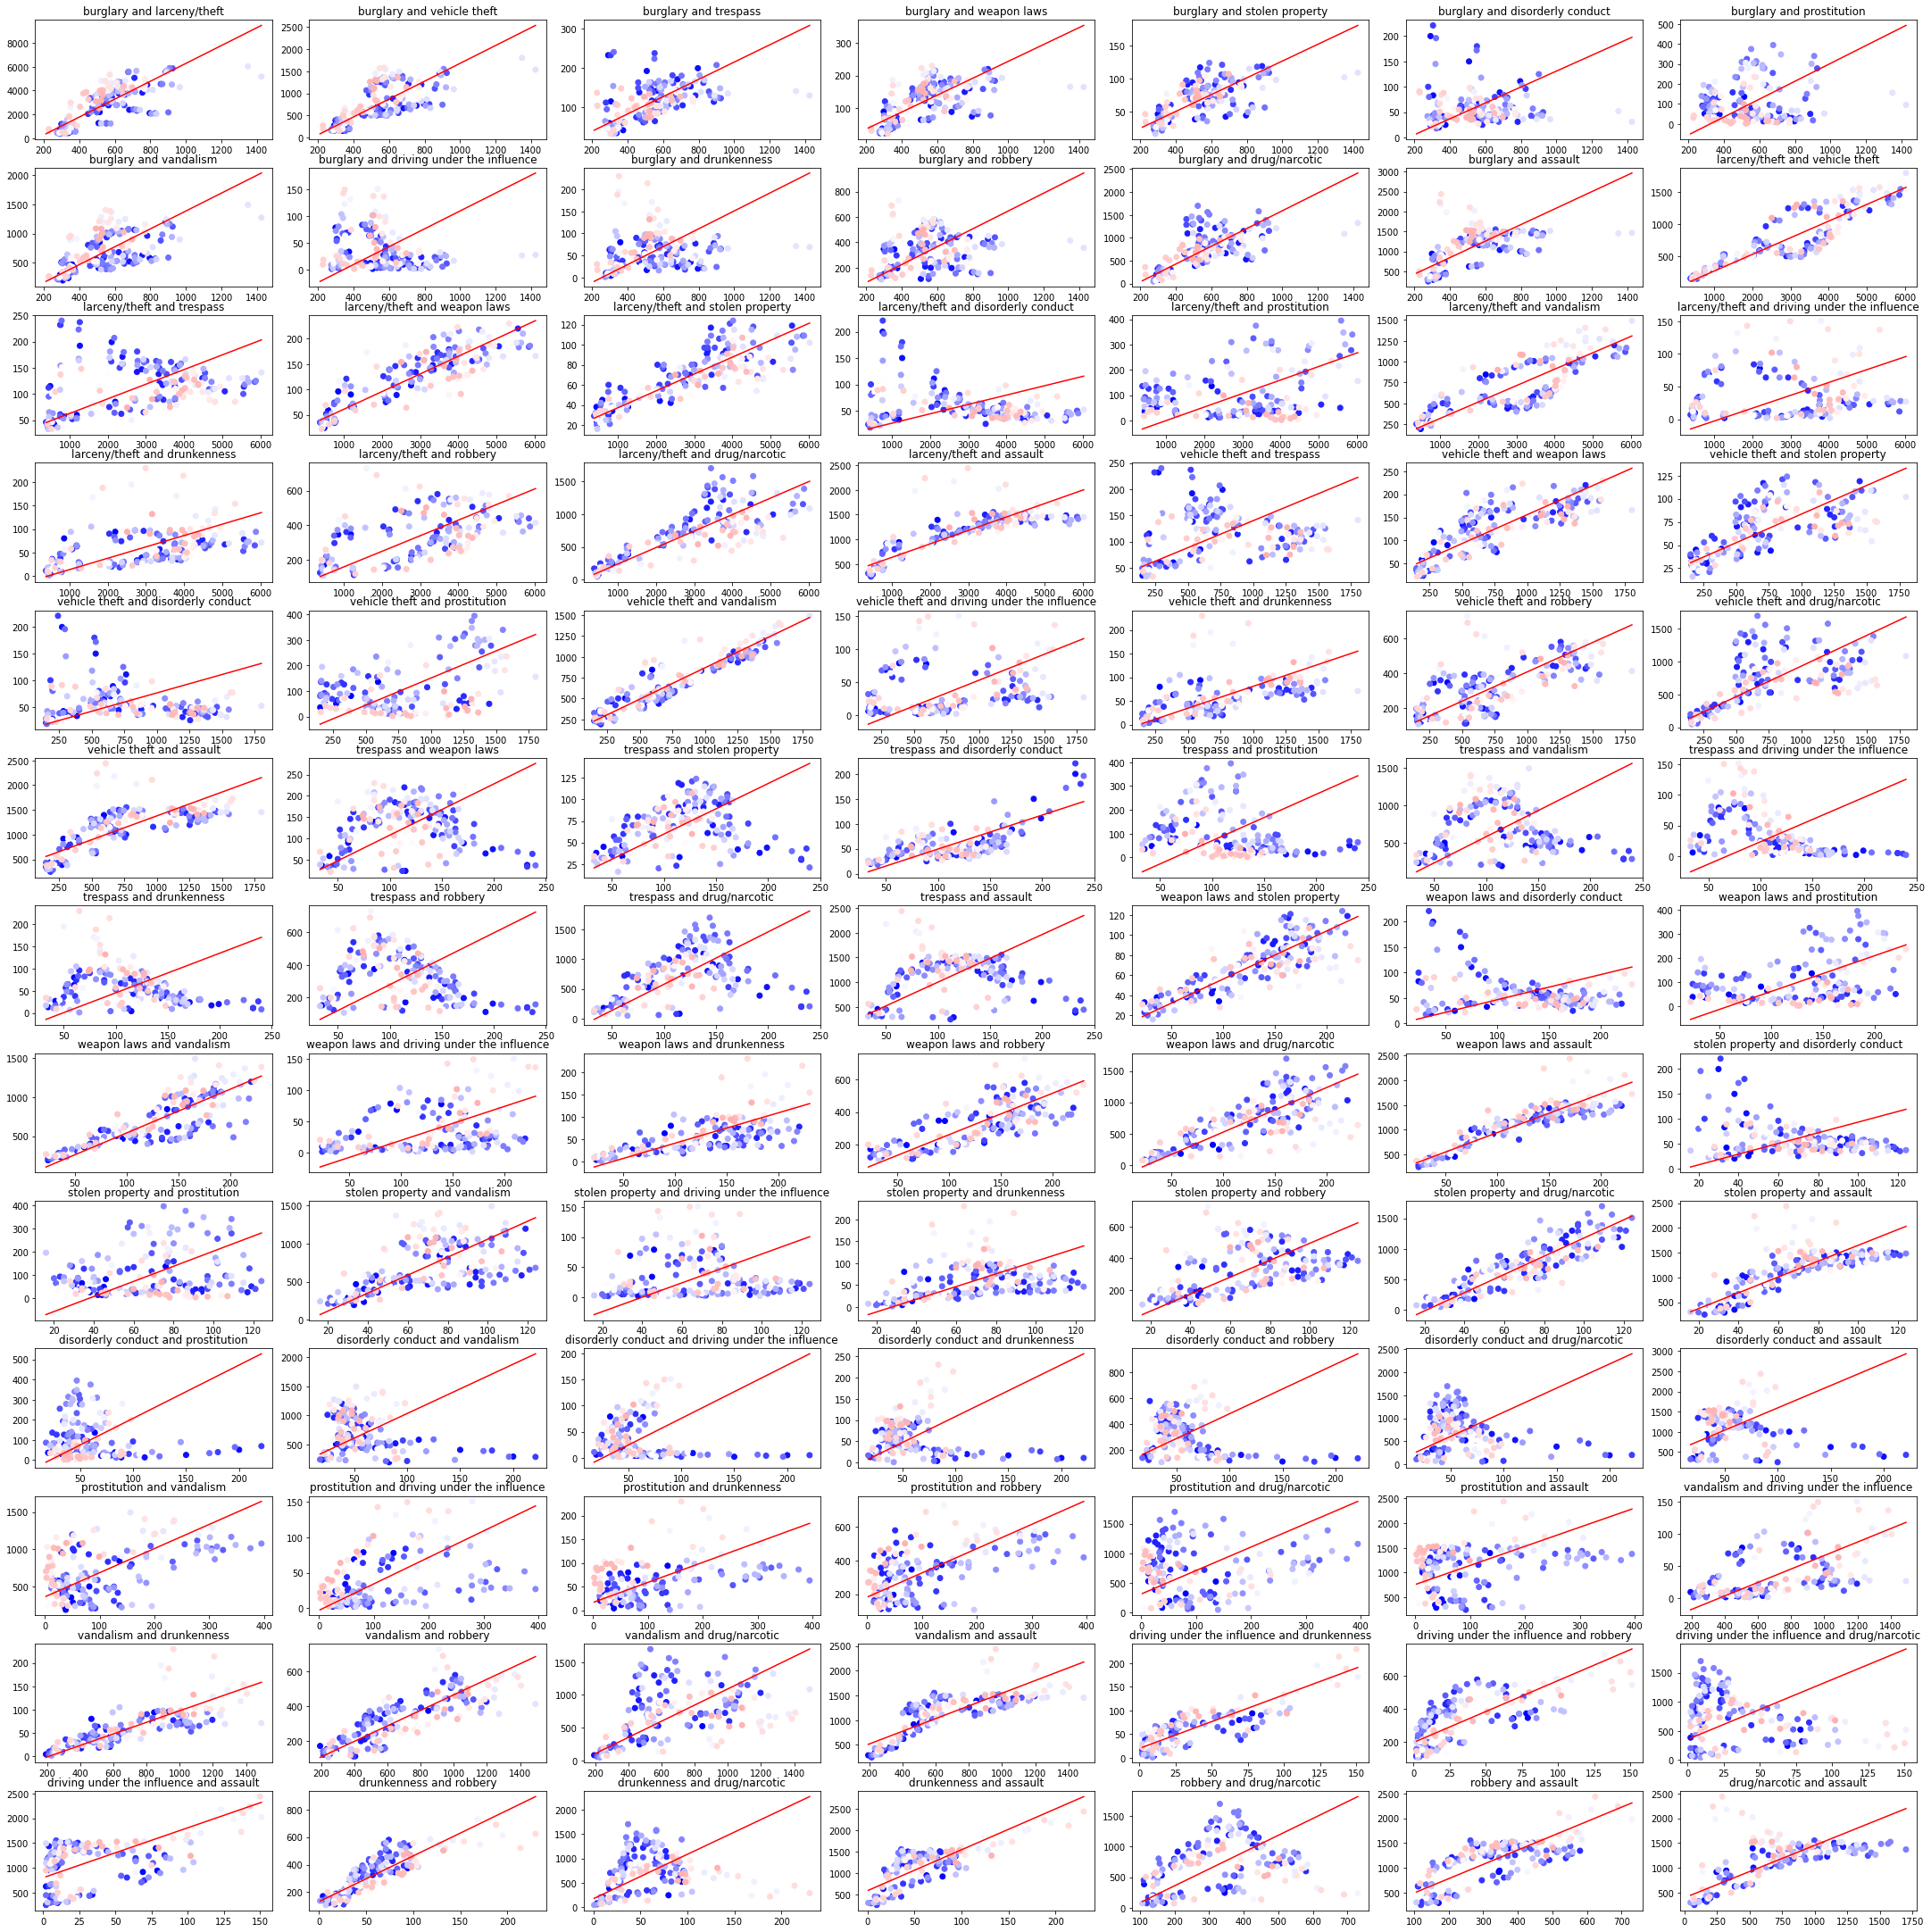

In [32]:
import matplotlib.cm as cm
import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue"])
fig, axes = plt.subplots(ncols=7, nrows=13, figsize=(30,30))
plt.tight_layout()
colors = [cm.bwr(i) for i in range(len(df.HourOfWeek.unique()))]

for (crime1, crime2), ax in zip(combinations(focuscrimes, r=2), axes.flat):
    x = df.HourOfWeek.loc[df.Category == crime1].groupby(df.HourOfWeek).agg('count').sort_values()
    y = df.HourOfWeek.loc[df.Category == crime2].groupby(df.HourOfWeek).agg('count').sort_values()
    
    xy = 0
    x2 = 0
    
    for val_x, val_y in zip(x,y):
        xy += val_x*val_y
        x2 += val_x**2
    
    a = (xy-len(x)*np.mean(x)*np.mean(y))/(x2-len(x)*np.mean(x)**2)
    b = np.mean(y) - a*np.mean(x)
    
    ax.scatter(x.sort_index(), y.sort_index(), color=colors)
    
    #ax.scatter(x, y)
    ax.plot(x, b+a*x, 'r')
    ax.title.set_text("{} and {}".format(crime1.lower(), crime2.lower()))

## Double checking

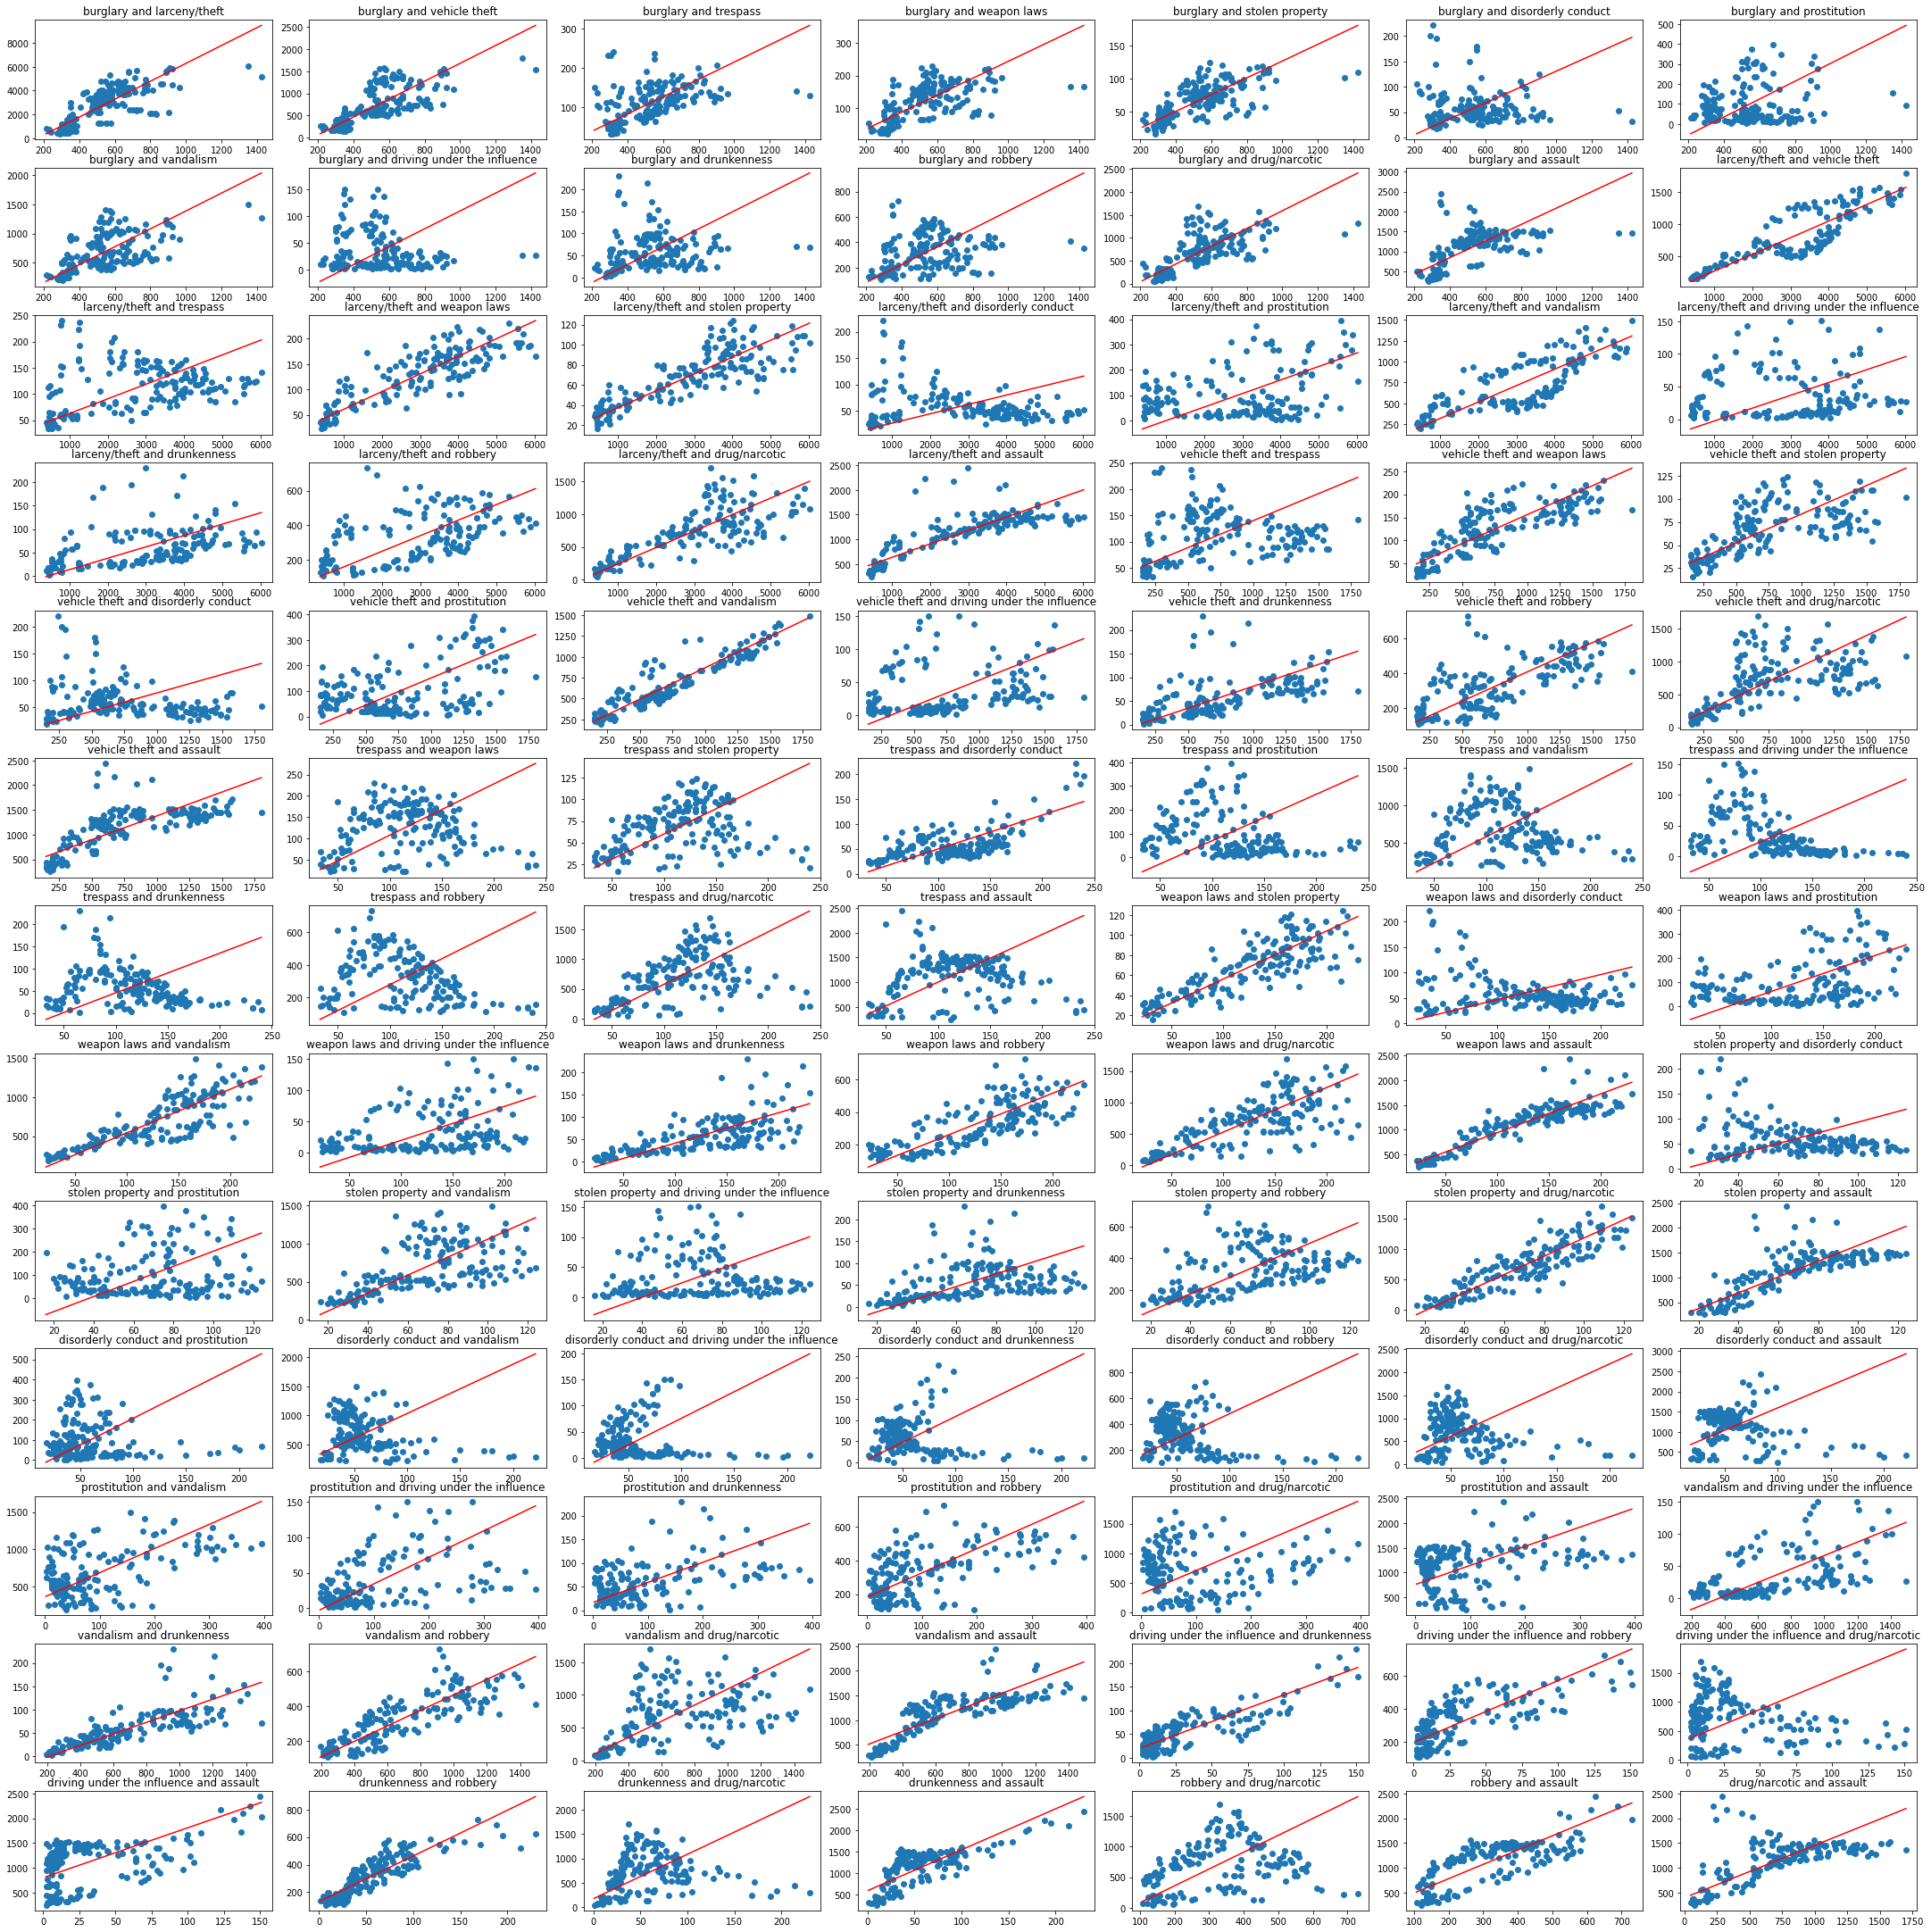

In [22]:
from numpy.polynomial.polynomial import polyfit
fig, axes = plt.subplots(ncols=7, nrows=13, figsize=(30,30))
plt.tight_layout()
for (crime1, crime2), ax in zip(combinations(focuscrimes, r=2), axes.flat):
    x = df.HourOfWeek.loc[df.Category == crime1].groupby(df.HourOfWeek).agg('count').sort_values()
    y = df.HourOfWeek.loc[df.Category == crime2].groupby(df.HourOfWeek).agg('count').sort_values()
    
    
    b, a = polyfit(x, y, 1)
    
    ax.scatter(x.sort_index(), y.sort_index())
    
    #ax.scatter(x, y)
    ax.plot(x, b+a*x, color='r')
    ax.title.set_text("{} and {}".format(crime1.lower(), crime2.lower()))

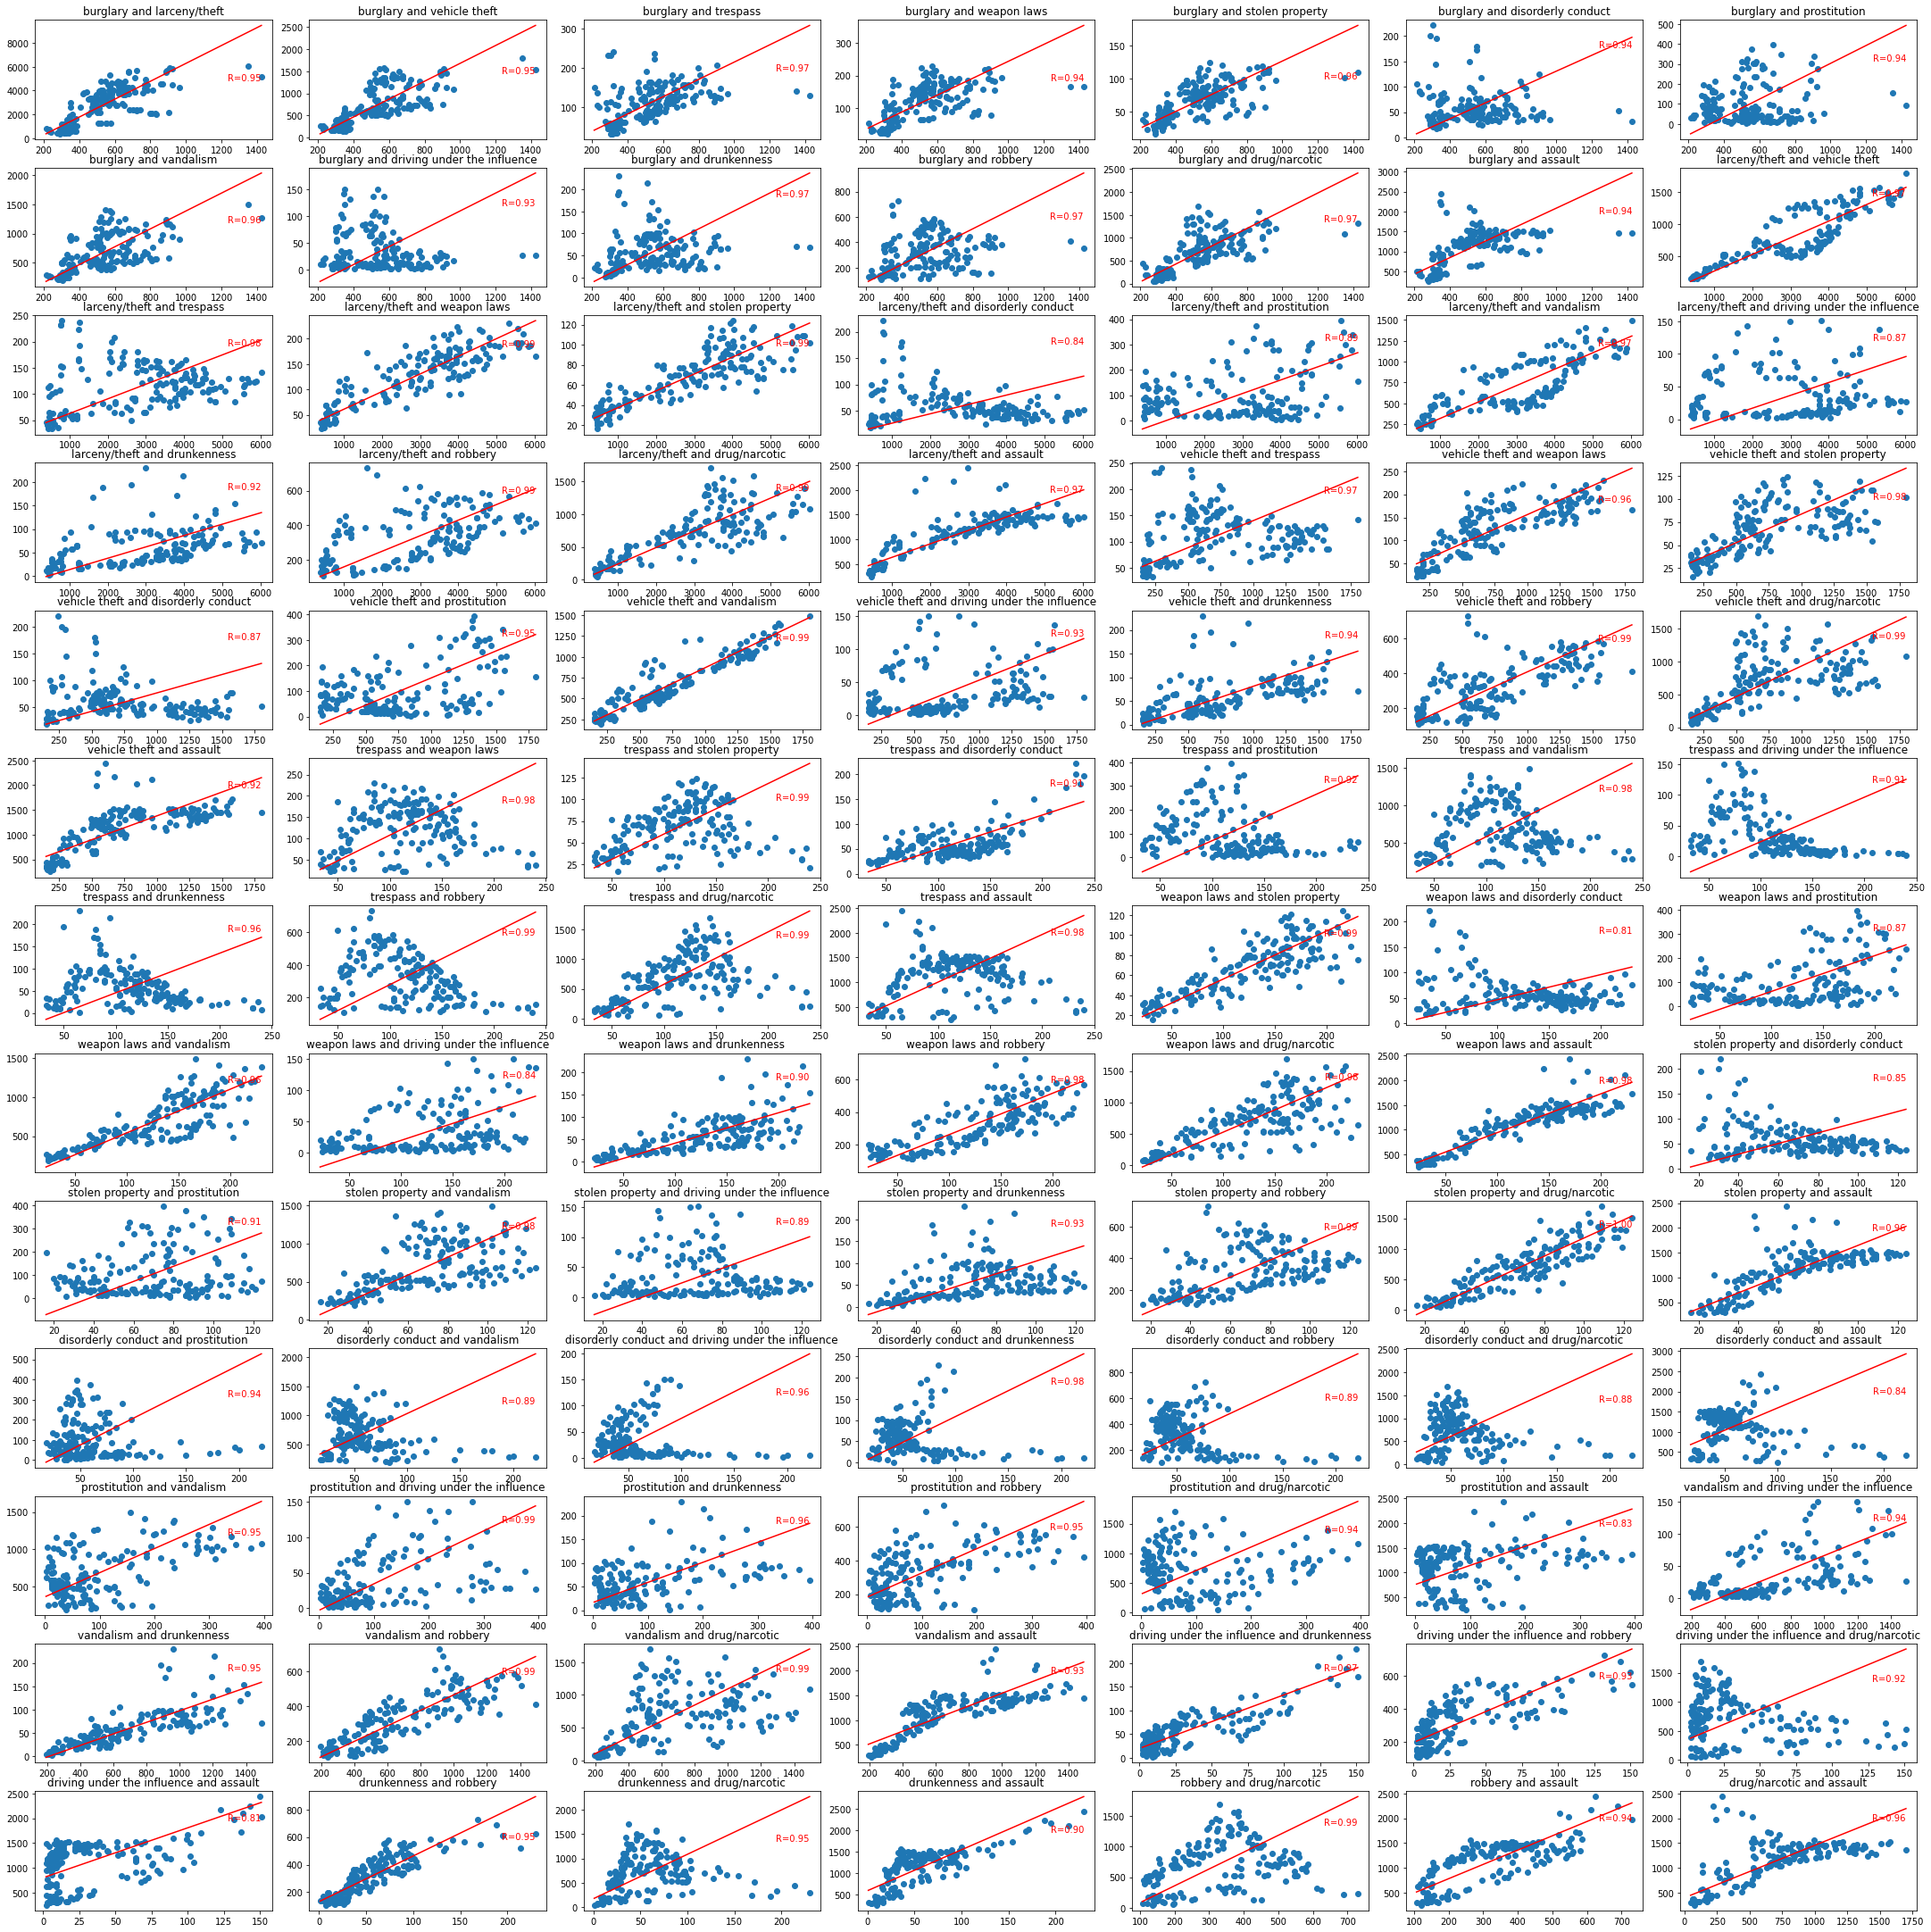

In [25]:
from scipy import stats

fig, axes = plt.subplots(ncols=7, nrows=13, figsize=(30,30))
plt.tight_layout()
for (crime1, crime2), ax in zip(combinations(focuscrimes, r=2), axes.flat):
    x = df.HourOfWeek.loc[df.Category == crime1].groupby(df.HourOfWeek).agg('count').sort_values()
    y = df.HourOfWeek.loc[df.Category == crime2].groupby(df.HourOfWeek).agg('count').sort_values()
    
    ax.scatter(x.sort_index(), y.sort_index())
    
    a, b, r_value, p_value, std_err = stats.linregress(x, y)
    ax.text(max(x), max(y)*0.8, 'R={:2.2f}'.format(r_value),horizontalalignment='right', color="red")
    ax.plot(x, b+a*x, color='r')
    ax.title.set_text("{} and {}".format(crime1.lower(), crime2.lower()))

*Exercise:* 
> * Write a little function to calculate $R^2$ alongside each linear fit.
> * According to your fits and associated measure of $R^2$, which pair of crimes have the most similar temporal pattern. Discuss your finding: Does it make sense? Why?/Why not?
> * According to your fits and associated measure of $R^2$, which pair of crimes have the most **dis**similar temporal pattern. Discuss your finding: Does it make sense? Why?/Why not?
> * Explain the connection between $R^2$ and the (Pearson correlation coefficient)[https://en.wikipedia.org/wiki/Pearson_correlation_coefficient].
> * And speaking of correlations. In your words, explain the [Spearman correlation](https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient)? How is it different for the Pearson correlation?